In [ ]:
#在这个设定下，共有941388310113310665080832个状态，9.41*10^23
# in this file
# we analyse the influence of different setting
# at the repairing center

In [58]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm

In [59]:
# initialize parameters
rate = {'lambda0' : 10.0,
        'lambda1' : 10.0,
        'lambda2' : 8.0,
        'lambda3' : 12.0,
        'car_move': 1.0,
        'gamma' : 1.0,
        'n_server' : 1,
        'phi' : 5.0,
        'delta' : 1.0,
        'broken' : 0.15,
        'period' : 90, #the maximal time for a carrier to move among areas
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
pij = [[0.1, 0.2, 0.3, 0.4],
       [0.2, 0.1, 0.3, 0.4],
       [0.3, 0.2, 0.1, 0.4],
       [0.4, 0.2, 0.3, 0.1],]

# QN

In [84]:
# simulate situation with collect, fix and redistribute
# in this version, bikes found broken after a customer RIDING
class BikeNet():
    def __init__(self, N, A, R, P, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.time_limit = run_time
        self.C = 0
        self.F = 0
        self.D = 0
        
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))

        self.served_customers = 0


    def reset(self):
        self.T = 0
        #queues: A0, A1, C, F, D, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+3)
        self.scheduler = []
        self.served_customers=0
        self.n = 0
        self.C = 0
        self.F = 0
        self.D = 0
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        self.fq = []
        heapq.heapify(self.fq)
        return self.state + [self.T]

    def simulate(self, writefile):
        if writefile:
            with open(writefile, 'w') as fout:
                writer = csv.writer(fout)
                writer.writerow(self.R)
                writer.writerow(self.R.values())
                writer.writerow(self.reset())
                while self.T <= self.time_limit:
                    writer.writerow(self.step())
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
        #return self.served_customers / (self.T-10000), self.n / 4000
        return self.served_customers / (self.T-6000)
                
    def get_rho(self, path):
        s, t = int(path[0]), int(path[1])
        if s==t: return 0.5
        elif abs(s-t) == 2: return 2.0
        else: return 1.0
                
    def get_index(self, target):
        if target == 'c': return self.A
        elif target == 'f': return self.A+1
        elif target == 'd': return self.A+2
        else:
            s, t = int(target[0]), int(target[1])
            return self.A+3 + self.A*s + t
        
    def add_event(self, kind):
        if kind == 2: 
            next_time = random.expovariate(self.R['gamma']) + max(self.T, self.C)
            self.C, start, end = next_time, 'c', 'f'
        elif kind == 3: 
#             next_time = random.expovariate(self.R['phi']) + max(self.T, self.F)
#             self.F, start, end = next_time, 'f', 'd'
            if self.state[self.A+1] <= self.R['n_server']:
                #print(self.state, self.fixing)
                next_time = random.expovariate(self.R['phi']) + self.T
                start, end= 'f', 'd'
                heapq.heappush(self.fq, next_time)
                #print(self.state, self.fq, '\n')
            else:
                #print(self.state, self.fq, '\n')
                next_time = random.expovariate(self.R['phi']) + self.fq[0]
                start, end = 'f', 'd'
                heapq.heappop(self.fq)
                heapq.heappush(self.fq, next_time)
            
        elif kind == 4: 
            next_time = random.expovariate(self.R['delta']) + max(self.T, self.D)
            self.D, start, end = next_time, 'd', random.choice([0,1])
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         1: a bike arrives
         2: a broken bike was collected
         3: a bike was fixed
         4: a bike was distributed
        '''
        if kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()<self.R['broken']:
                self.state[self.A] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2)
            else:
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state[self.A] -= 1
            self.state[self.A+1] += 1
            heapq.heappop(self.scheduler)
            self.add_event(3)
        elif kind == 3:
            self.state[self.A+1] -= 1
            self.state[self.A+2] += 1
            heapq.heappop(self.scheduler)
            self.add_event(4)
        elif kind == 4:
            self.state[self.A+2] -= 1
            self.state[terminal] += 1
            heapq.heappop(self.scheduler)
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                #if self.T>10000: self.served_customers += 1
                if self.T>6000: self.served_customers += 1
                #self.served_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.get_rho(target)) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = rate
P = pij


run_time = 10000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              run_time=run_time)
              #start_position=0)
result = []
for j in range(1, 10):
    print(env.simulate(0))
# for i in range(10):
#     env.R['gamma'] = i+1
#     for j in range(10):
#         env.R['phi'] = j+1
#         for k in range(10):
#             env.R['delta'] = k+1
#             for l in tqdm(range(1,5)):
#                 env.R['n_server'] = l

#                 result.append([i,j,k,l]+[env.simulate(0)])
    
# plt.plot(result)
# plt.show()

6.388432341144026
6.560989619752732
6.357490212541009
6.5112491758343705
6.717716109406539
6.701446983279734
6.679999035880492
6.491486843224286
6.632492831872523


In [ ]:
(6.608999957175261, 6.74775)
(6.549797119576936, 6.388)
(6.523895206191611, 6.60825)
(6.598267064335717, 6.67075)
(6.540991924236035, 6.751)
(6.554398742245478, 6.68525)
(6.656494811094626, 6.8005)
(6.560492563733929, 6.565)
(6.729882256203007, 6.306)

In [62]:
# central模型中运维中心参数设置的影响
address = '/Users/valarian/SJTU/SJTU/毕业论文/Data/simulationResult/学院服务器结果/simulationResult/central/data/central_server_QN_result.csv'
df = pd.read_csv(address, header=None, squeeze=True)

#df_stack = df.stack()[0]

In [80]:
columns = ['gamma', 'phi', 'delta', 'n_server', 'avg_cus']
dtype = [np.int, np.int, np.int, np.int, np.float]
df = pd.DataFrame([df_stack[i][1:-1].split(', ') for i in range(len(df_stack))], columns=columns)
df.gamma = df.gamma.astype(np.int)
df.phi = df.phi.astype(np.int)
df.delta = df.delta.astype(np.int)
df.n_server = df.n_server.astype(np.int)
df.avg_cus = df.avg_cus.astype(np.float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
gamma       4000 non-null int64
phi         4000 non-null int64
delta       4000 non-null int64
n_server    4000 non-null int64
avg_cus     4000 non-null float64
dtypes: float64(1), int64(4)
memory usage: 156.4 KB


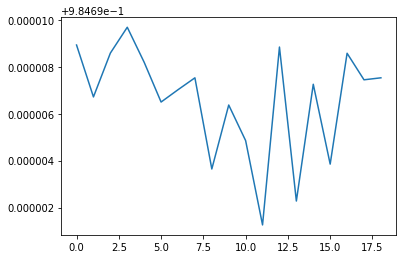

In [65]:
result_gamma = []
for j in range(1, 20):
    env.R['gamma'] = j
    save_address = '/Users/valarian/SJTU/SJTU/毕业论文/Data/simulationResult/central/data/gamma/central_gamma_'+ str(j) +'_1_1_100.csv'
    result_gamma.append(env.simulate(save_address))
    
plt.plot(result_gamma)
plt.show()

# Real

In [ ]:
# the influence of phi
# in this version, carrier moves among areas to collect broken bikes
# then brings them to the repair center, and bring the normal bikes back to areas
class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        #self.C = 0
        self.F = 0
        #self.D = 0
        self.capacity = self.R['capacity']
        self.areas = list(range(A))

        self.serverd_customers = 0

    def reset(self):
        self.T = 0
#         self.C = 0
        self.F = 0
#         self.D = 0
        self.serverd_customers = 0
        self.fq = []
        heapq.heapify(self.fq)
        #queues: A0, A1, B0, B1, FN, FB, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2+self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #event of the carrier, [time, kind, place, [normal, broken, time]]
        heapq.heappush(self.scheduler, [0, 0, 0, [0,0,self.T+self.R['period']]])
        #return self.state + [self.T]

    def simulate(self):
        self.reset()
        while self.T <= self.time_limit:
            self.step()
        return self.serverd_customers/(self.T-6000)
                
    def get_rho(self, path):
        s, t = int(path[0]), int(path[1])
        if s==t: return 0.5
        elif abs(s-t) == 2: return 2.0
        else: return 1.0
                
    def get_index(self, target):
        if target == 'c': return self.A
        elif target == 'f': return self.A+1
        elif target == 'd': return self.A+2
        else:
            s, t = int(target[0]), int(target[1])
            return 2*self.A + 2 + self.A*s + t
        
    def add_event(self, kind, s):
        if kind == 2:
            next_time = random.expovariate(self.R['gamma']) + self.T
            start, end = s, 'f'
        elif kind == 3:
            if self.state[2*self.A+1] <= self.R['n_server']:
                #print(self.state, self.fixing)
                next_time = random.expovariate(self.R['phi']) + self.T
                start, end= 'f', 'd'
                heapq.heappush(self.fq, next_time)
                #print(self.state, self.fq, '\n')
            else:
                #print(self.state, self.fq, '\n')
                next_time = random.expovariate(self.R['phi']) + self.fq[0]
                start, end = 'f', 'd'
                heapq.heappop(self.fq)
                heapq.heappush(self.fq, next_time)
        elif kind == 0:
            next_time = random.expovariate(self.R['delta']) + self.T
            start, end = random.choice(list(range(self.A))), [s, 0, self.T+self.R['period']]
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         0: carrier arrives as a area
         1: a bike arrives
         2: carrier full of broken bikes arrives as the repairing center
         3: a bike was fixed
        '''
        if kind == 0: #carrier 正在areas之间逡巡中，鱼戏莲叶南，鱼戏莲叶北
            normal, broken, end_time = terminal[0], terminal[1], terminal[2]
            if normal > 0: #如果有好车，先把好车放下
                #print(self.scheduler[0])
                #print('holla', normal, broken)
                number = min(normal, int(self.capacity/self.A))
                self.state[start] += number
                self.scheduler[0][3][0] -= number
                normal -= number
                #print(self.scheduler[0])
                #print(self.state, '\n')
            if self.state[self.A+start]>0 and broken < self.capacity: #如果有坏车，并且运载车没满，把坏车装上运载车
                number = min(self.capacity - broken, self.state[self.A + start])
                self.state[self.A+start] -= number
                self.scheduler[0][3][1] += number
                broken += number
            if broken == self.capacity or (self.T>end_time and normal==0):
                heapq.heappop(self.scheduler)
                self.add_event(2, broken)
            else:
                self.scheduler[0][0] += random.expovariate(self.R['car_move'])
                self.scheduler[0][2] = (start+1)%4
                heapq.heapify(self.scheduler) 
        elif kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()<self.R['broken']:
                self.state[self.A+terminal] += 1
                heapq.heappop(self.scheduler)
            else:
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            if self.state[self.A * 2 + 1]==0:
                self.add_event(3, start)
            self.state[self.A * 2 + 1] += start
            heapq.heappop(self.scheduler)
            number = min(self.capacity, self.state[self.A * 2])
            self.add_event(0, number)
            self.state[self.A * 2] -= number
        elif kind == 3:
            #print(self.state)
            self.state[self.A * 2] += 1
            self.state[self.A * 2 + 1] -= 1
            heapq.heappop(self.scheduler)
            if self.state[self.A * 2 + 1] > 0:
                self.add_event(3, start)
                #print('next fix')
            #print(self.state)
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                if self.T>6000: self.serverd_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.get_rho(target)) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        #return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space

#setting of the QN
R = {'lambda0' : 10.0,
    'lambda1' : 10.0,
    'lambda2' : 8.0,
    'lambda3' : 12.0,
    'car_move': 1.0,
    'capacity' : 12,
    'gamma' : 1.0,
    'phi' : 5.0,
    'n_fix' : 2,
    'delta' : 1.0,
    'broken' : 0.15,
    'period' : 90, #the maximal time for a carrier to move among areas
   }

P =  [[0.1, 0.2, 0.3, 0.4],
       [0.2, 0.1, 0.3, 0.4],
       [0.3, 0.2, 0.1, 0.4],
       [0.4, 0.2, 0.3, 0.1],]


run_time = 10000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)

result = []
env.R['gamma'] = 200
env.R['delta'] = 200
env.R['car_move'] = 200
for i in range(100,102):
    env.R['phi'] = i*0.1
    result.append(env.simulate())
    
plt.plot(result)
plt.show()